#REAL-TIME MACHINE LEARNING(ECGR 5106)

HOMEWORK 2

Naseeruddin Lodge

801200144


In [4]:
#install specific version of d2l
#install ptflops
!pip install d2l==1.0.0b0
!pip install ptflops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 42.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.4 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616821 sha256=9a03678788ac84383aac2eb21ce60d0bfb50a4fb6893b7abe7bbbf0d6648c873
  Stored in directory: /root/.cache/pip/wheels/27/6d/b3/a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
Successfully built gym
  Attempting uninstal

In [5]:
# Importing required libraries
%matplotlib inline
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch import nn
from d2l import torch as d2l
import ptflops
from ptflops import get_model_complexity_info

d2l.use_svg_display()
     

#PROBLEM 1


FashionMNIST baseline version


In [6]:
# Loading the FashionMNIST Dataset 
class FashionMNIST(d2l.DataModule):
  def __init__(self, batch_size = 64, resize = (28, 28)):
    super().__init__()
    self.save_hyperparameters()
    trans = transforms.Compose([transforms.Resize(resize),
                                transforms.ToTensor()])
    self.train = torchvision.datasets.FashionMNIST(
        root = self.root, train = True, transform = trans, download = True)
    self.val = torchvision.datasets.FashionMNIST(
        root = self.root, train = False, transform = trans, download = True)

In [7]:
data = FashionMNIST(resize = (32, 32))
print("Training Images   = ", len(data.train))
print("Validation Images = ", len(data.val))

data.train[0][0].shape

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

Training Images   =  60000
Validation Images =  10000


torch.Size([1, 32, 32])

In [8]:
# Assigning labels to numerical values so its is easier to read 
@d2l.add_to_class(FashionMNIST)
def text_labels(self, indices):
  labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 
           'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
  return [labels[int(i)] for i in indices]

In [9]:
# Function to load either Training or Validation self
@d2l.add_to_class(FashionMNIST)
def get_dataloader(self, train):
  data = self.train if train else self.val
  return torch.utils.data.DataLoader(data, self.batch_size, shuffle = train,
                                     num_workers = self.num_workers)
  
X, Y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, Y.shape, Y.dtype)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([64, 1, 32, 32]) torch.float32 torch.Size([64]) torch.int64


In [10]:
# Function that initialized the weights of the CNN model with Xavier Uniform Initialization
def init_cnn(module):  
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

In [11]:
# The Baseline Convolution Neural Network 
class LeNet_Base(d2l.Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))


In [12]:
# Function to print a Model's Layer Summary given the shape
@d2l.add_to_class(d2l.Classifier) 
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet_Base()
model.layer_summary((1, 1, 32, 32))
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 32, 32))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))
     

Conv2d output shape:	 torch.Size([1, 6, 32, 32])
Sigmoid output shape:	 torch.Size([1, 6, 32, 32])
AvgPool2d output shape:	 torch.Size([1, 6, 16, 16])
Conv2d output shape:	 torch.Size([1, 16, 12, 12])
Sigmoid output shape:	 torch.Size([1, 16, 12, 12])
AvgPool2d output shape:	 torch.Size([1, 16, 6, 6])
Flatten output shape:	 torch.Size([1, 576])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])
Sequential(
  82.83 k, 100.000% Params, 596.35 KMac, 100.000% MACs, 
  (0): Conv2d(156, 0.188% Params, 159.74 KMac, 26.787% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
  (2): AvgPool2d(0, 0.000% Params, 6.14 KMac, 1.030% MACs, kernel_size=2, stride=2, padding=0)
  (3): Conv2d(2.42 k, 2.917% Params, 347.9 KMac, 58.339% MACs, 6, 16, kernel_size=(5, 5), stride=(1,

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [13]:
# Function to Evaluate the Model's Accuracy
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()  
        if not device:
            device = next(iter(net.parameters())).device

    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [14]:
# Training Function 
def train(net, train_iter, val_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'val acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        val_acc = evaluate_accuracy_gpu(net, val_iter)
        animator.add(epoch + 1, (None, None, val_acc))

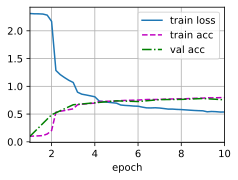

In [ ]:
lr, num_epochs = 0.1, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

Taking the base model of FashionMNIST and replacing the average pooling with max-pooling
Also replacing softmax layer with ReLU

In [ ]:
# Modernized LeNet Model for Problem # 1
# For Problem # 1, The Average Pooling will be replaced with Max Pooling,
# and the Softmax/Sigmoid layer with ReLU

class LeNet_Modernize(d2l.Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))
        
model = LeNet_Modernize()
model.layer_summary((1, 1, 32, 32))

Conv2d output shape:	 torch.Size([1, 6, 32, 32])
ReLU output shape:	 torch.Size([1, 6, 32, 32])
MaxPool2d output shape:	 torch.Size([1, 6, 16, 16])
Conv2d output shape:	 torch.Size([1, 16, 12, 12])
ReLU output shape:	 torch.Size([1, 16, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 16, 6, 6])
Flatten output shape:	 torch.Size([1, 576])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


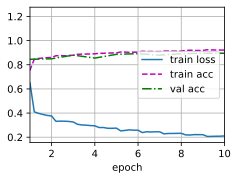

In [ ]:
lr, num_epochs = 0.1, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

#PROBLEM 2

1. Adjust the convolution window size.

In [ ]:
class LeNet_1(d2l.Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=9, padding=3), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=7), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))
        
model = LeNet_1()
model.layer_summary((1, 1, 32, 32))

# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 32, 32))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Conv2d output shape:	 torch.Size([1, 6, 30, 30])
ReLU output shape:	 torch.Size([1, 6, 30, 30])
MaxPool2d output shape:	 torch.Size([1, 6, 15, 15])
Conv2d output shape:	 torch.Size([1, 16, 9, 9])
ReLU output shape:	 torch.Size([1, 16, 9, 9])
MaxPool2d output shape:	 torch.Size([1, 16, 4, 4])
Flatten output shape:	 torch.Size([1, 256])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])
Sequential(
  47.07 k, 100.000% Params, 880.57 KMac, 100.000% MACs, 
  (0): Conv2d(492, 1.045% Params, 442.8 KMac, 50.286% MACs, 1, 6, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
  (1): ReLU(0, 0.000% Params, 5.4 KMac, 0.613% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 5.4 KMac, 0.613% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(4.72 k, 10.028% Params, 382.32 KMac, 43.417% MACs, 6, 16, kernel_size=(7, 7),

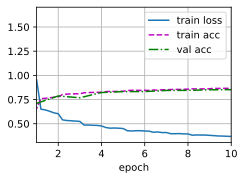

In [ ]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

2. Adjust the number of output channels (width of each layer).

In [ ]:
class LeNet_2(d2l.Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(4, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(8, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))
        
model = LeNet_2()
model.layer_summary((1, 1, 32, 32))


Conv2d output shape:	 torch.Size([1, 4, 32, 32])
ReLU output shape:	 torch.Size([1, 4, 32, 32])
MaxPool2d output shape:	 torch.Size([1, 4, 16, 16])
Conv2d output shape:	 torch.Size([1, 8, 12, 12])
ReLU output shape:	 torch.Size([1, 8, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 8, 6, 6])
Flatten output shape:	 torch.Size([1, 288])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 32, 32))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential(
  46.61 k, 100.000% Params, 279.24 KMac, 100.000% MACs, 
  (0): Conv2d(104, 0.223% Params, 106.5 KMac, 38.138% MACs, 1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 4.1 KMac, 1.467% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 4.1 KMac, 1.467% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(808, 1.734% Params, 116.35 KMac, 41.667% MACs, 4, 8, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU(0, 0.000% Params, 1.15 KMac, 0.413% MACs, )
  (5): MaxPool2d(0, 0.000% Params, 1.15 KMac, 0.413% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
  (7): Linear(34.68 k, 74.411% Params, 34.68 KMac, 12.419% MACs, in_features=288, out_features=120, bias=True)
  (8): ReLU(0, 0.000% Params, 120.0 Mac, 0.043% MACs, )
  (9): Linear(10.16 k, 21.808% Params, 10.16 KMac, 3.640% MACs, in_features=120, out_features=84, bias=True

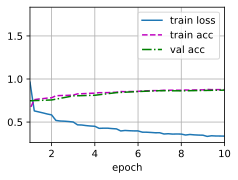

In [ ]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

3. Adjust the number of convolution layers.

In [ ]:
class LeNet_3(d2l.Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(32, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(64, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))
        
model = LeNet_3()
model.layer_summary((1, 1, 32, 32))

Conv2d output shape:	 torch.Size([1, 6, 32, 32])
ReLU output shape:	 torch.Size([1, 6, 32, 32])
MaxPool2d output shape:	 torch.Size([1, 6, 16, 16])
Conv2d output shape:	 torch.Size([1, 16, 12, 12])
ReLU output shape:	 torch.Size([1, 16, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 16, 6, 6])
Conv2d output shape:	 torch.Size([1, 32, 6, 6])
ReLU output shape:	 torch.Size([1, 32, 6, 6])
MaxPool2d output shape:	 torch.Size([1, 32, 3, 3])
Conv2d output shape:	 torch.Size([1, 64, 3, 3])
ReLU output shape:	 torch.Size([1, 64, 3, 3])
MaxPool2d output shape:	 torch.Size([1, 64, 1, 1])
Flatten output shape:	 torch.Size([1, 64])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 32, 32))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential(
  85.48 k, 100.000% Params, 1.47 MMac, 100.000% MACs, 
  (0): Conv2d(156, 0.182% Params, 159.74 KMac, 10.864% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 6.14 KMac, 0.418% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 6.14 KMac, 0.418% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(2.42 k, 2.826% Params, 347.9 KMac, 23.661% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU(0, 0.000% Params, 2.3 KMac, 0.157% MACs, )
  (5): MaxPool2d(0, 0.000% Params, 2.3 KMac, 0.157% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(12.83 k, 15.011% Params, 461.95 KMac, 31.418% MACs, 16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (7): ReLU(0, 0.000% Params, 1.15 KMac, 0.078% MACs, )
  (8): MaxPool2d(0, 0.000% Params, 1.15 KMac, 0.078% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(51.26 k, 59.971% Params, 461.38 K

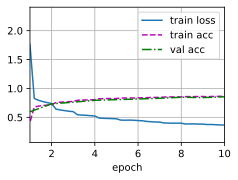

In [ ]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

4. Adjust the number of fully connected layers

In [ ]:
class LeNet_4(d2l.Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(64), nn.ReLU(),
            nn.LazyLinear(num_classes))
        
model = LeNet_4()
model.layer_summary((1, 1, 32, 32))

Conv2d output shape:	 torch.Size([1, 6, 32, 32])
ReLU output shape:	 torch.Size([1, 6, 32, 32])
MaxPool2d output shape:	 torch.Size([1, 6, 16, 16])
Conv2d output shape:	 torch.Size([1, 16, 12, 12])
ReLU output shape:	 torch.Size([1, 16, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 16, 6, 6])
Flatten output shape:	 torch.Size([1, 576])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 64])
ReLU output shape:	 torch.Size([1, 64])
Linear output shape:	 torch.Size([1, 10])


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 32, 32))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential(
  88.07 k, 100.000% Params, 610.31 KMac, 100.000% MACs, 
  (0): Conv2d(156, 0.177% Params, 159.74 KMac, 26.174% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 6.14 KMac, 1.007% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 6.14 KMac, 1.007% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(2.42 k, 2.743% Params, 347.9 KMac, 57.005% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU(0, 0.000% Params, 2.3 KMac, 0.378% MACs, )
  (5): MaxPool2d(0, 0.000% Params, 2.3 KMac, 0.378% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
  (7): Linear(69.24 k, 78.623% Params, 69.24 KMac, 11.345% MACs, in_features=576, out_features=120, bias=True)
  (8): ReLU(0, 0.000% Params, 120.0 Mac, 0.020% MACs, )
  (9): Linear(10.16 k, 11.541% Params, 10.16 KMac, 1.665% MACs, in_features=120, out_features=84, bias=

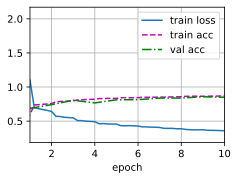

In [ ]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

5. Explore the learning rates

In [ ]:
class LeNet_5(d2l.Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.LazyLinear(84), nn.ReLU(),
            nn.LazyLinear(num_classes))

model = LeNet_5()
model.layer_summary((1, 1, 32, 32))

Conv2d output shape:	 torch.Size([1, 6, 32, 32])
ReLU output shape:	 torch.Size([1, 6, 32, 32])
MaxPool2d output shape:	 torch.Size([1, 6, 16, 16])
Conv2d output shape:	 torch.Size([1, 16, 12, 12])
ReLU output shape:	 torch.Size([1, 16, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 16, 6, 6])
Flatten output shape:	 torch.Size([1, 576])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 32, 32))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential(
  82.83 k, 100.000% Params, 605.0 KMac, 100.000% MACs, 
  (0): Conv2d(156, 0.188% Params, 159.74 KMac, 26.404% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 6.14 KMac, 1.016% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 6.14 KMac, 1.016% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(2.42 k, 2.917% Params, 347.9 KMac, 57.505% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU(0, 0.000% Params, 2.3 KMac, 0.381% MACs, )
  (5): MaxPool2d(0, 0.000% Params, 2.3 KMac, 0.381% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
  (7): Linear(69.24 k, 83.597% Params, 69.24 KMac, 11.445% MACs, in_features=576, out_features=120, bias=True)
  (8): ReLU(0, 0.000% Params, 120.0 Mac, 0.020% MACs, )
  (9): Linear(10.16 k, 12.272% Params, 10.16 KMac, 1.680% MACs, in_features=120, out_features=84, bias=T

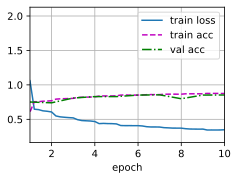

In [ ]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

#PROBLEM 3


In [ ]:
class LeNet_D1(d2l.Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=9, padding=3), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=7), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.Dropout(0.1),
            nn.LazyLinear(84), nn.ReLU(),
            nn.Dropout(0.1),
            nn.LazyLinear(num_classes))
        
model = LeNet_D1()
model.layer_summary((1, 1, 32, 32))

Conv2d output shape:	 torch.Size([1, 6, 30, 30])
ReLU output shape:	 torch.Size([1, 6, 30, 30])
MaxPool2d output shape:	 torch.Size([1, 6, 15, 15])
Conv2d output shape:	 torch.Size([1, 16, 9, 9])
ReLU output shape:	 torch.Size([1, 16, 9, 9])
MaxPool2d output shape:	 torch.Size([1, 16, 4, 4])
Flatten output shape:	 torch.Size([1, 256])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Dropout output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Dropout output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 32, 32))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential(
  47.07 k, 100.000% Params, 880.57 KMac, 100.000% MACs, 
  (0): Conv2d(492, 1.045% Params, 442.8 KMac, 50.286% MACs, 1, 6, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
  (1): ReLU(0, 0.000% Params, 5.4 KMac, 0.613% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 5.4 KMac, 0.613% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(4.72 k, 10.028% Params, 382.32 KMac, 43.417% MACs, 6, 16, kernel_size=(7, 7), stride=(1, 1))
  (4): ReLU(0, 0.000% Params, 1.3 KMac, 0.147% MACs, )
  (5): MaxPool2d(0, 0.000% Params, 1.3 KMac, 0.147% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
  (7): Linear(30.84 k, 65.525% Params, 30.84 KMac, 3.502% MACs, in_features=256, out_features=120, bias=True)
  (8): ReLU(0, 0.000% Params, 120.0 Mac, 0.014% MACs, )
  (9): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.1, inplace=False)
  (10): Linear(10.16 k, 21.5

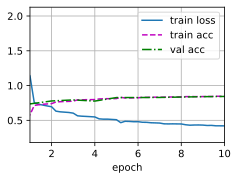

In [ ]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

In [ ]:
class LeNet_D2(d2l.Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(4, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(8, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.Dropout(0.1),
            nn.LazyLinear(84), nn.ReLU(),
            nn.Dropout(0.1),
            nn.LazyLinear(num_classes))
        
model = LeNet_D2()
model.layer_summary((1, 1, 32, 32))

Conv2d output shape:	 torch.Size([1, 4, 32, 32])
ReLU output shape:	 torch.Size([1, 4, 32, 32])
MaxPool2d output shape:	 torch.Size([1, 4, 16, 16])
Conv2d output shape:	 torch.Size([1, 8, 12, 12])
ReLU output shape:	 torch.Size([1, 8, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 8, 6, 6])
Flatten output shape:	 torch.Size([1, 288])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Dropout output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Dropout output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 32, 32))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential(
  46.61 k, 100.000% Params, 279.24 KMac, 100.000% MACs, 
  (0): Conv2d(104, 0.223% Params, 106.5 KMac, 38.138% MACs, 1, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 4.1 KMac, 1.467% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 4.1 KMac, 1.467% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(808, 1.734% Params, 116.35 KMac, 41.667% MACs, 4, 8, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU(0, 0.000% Params, 1.15 KMac, 0.413% MACs, )
  (5): MaxPool2d(0, 0.000% Params, 1.15 KMac, 0.413% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
  (7): Linear(34.68 k, 74.411% Params, 34.68 KMac, 12.419% MACs, in_features=288, out_features=120, bias=True)
  (8): ReLU(0, 0.000% Params, 120.0 Mac, 0.043% MACs, )
  (9): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.1, inplace=False)
  (10): Linear(10.16 k, 21.808

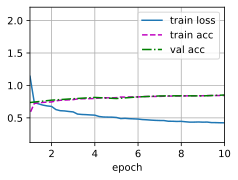

In [ ]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

In [ ]:
class LeNet_D3(d2l.Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(32, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(64, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.Dropout(0.1),
            nn.LazyLinear(84), nn.ReLU(),
            nn.Dropout(0.1),
            nn.LazyLinear(num_classes),)
        
model = LeNet_D3()
model.layer_summary((1, 1, 32, 32))

Conv2d output shape:	 torch.Size([1, 6, 32, 32])
ReLU output shape:	 torch.Size([1, 6, 32, 32])
MaxPool2d output shape:	 torch.Size([1, 6, 16, 16])
Conv2d output shape:	 torch.Size([1, 16, 12, 12])
ReLU output shape:	 torch.Size([1, 16, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 16, 6, 6])
Conv2d output shape:	 torch.Size([1, 32, 6, 6])
ReLU output shape:	 torch.Size([1, 32, 6, 6])
MaxPool2d output shape:	 torch.Size([1, 32, 3, 3])
Conv2d output shape:	 torch.Size([1, 64, 3, 3])
ReLU output shape:	 torch.Size([1, 64, 3, 3])
MaxPool2d output shape:	 torch.Size([1, 64, 1, 1])
Flatten output shape:	 torch.Size([1, 64])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Dropout output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Dropout output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 32, 32))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential(
  85.48 k, 100.000% Params, 1.47 MMac, 100.000% MACs, 
  (0): Conv2d(156, 0.182% Params, 159.74 KMac, 10.864% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 6.14 KMac, 0.418% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 6.14 KMac, 0.418% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(2.42 k, 2.826% Params, 347.9 KMac, 23.661% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU(0, 0.000% Params, 2.3 KMac, 0.157% MACs, )
  (5): MaxPool2d(0, 0.000% Params, 2.3 KMac, 0.157% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(12.83 k, 15.011% Params, 461.95 KMac, 31.418% MACs, 16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (7): ReLU(0, 0.000% Params, 1.15 KMac, 0.078% MACs, )
  (8): MaxPool2d(0, 0.000% Params, 1.15 KMac, 0.078% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(51.26 k, 59.971% Params, 461.38 K

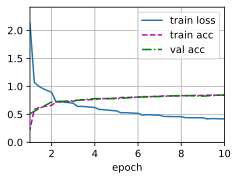

In [ ]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

In [ ]:
class LeNet_D4(d2l.Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.Dropout(0.1),
            nn.LazyLinear(84), nn.ReLU(),
            nn.Dropout(0.1),
            nn.LazyLinear(64), nn.ReLU(),
            nn.Dropout(0.1),
            nn.LazyLinear(num_classes),)
        
model = LeNet_D4()
model.layer_summary((1, 1, 32, 32))

Conv2d output shape:	 torch.Size([1, 6, 32, 32])
ReLU output shape:	 torch.Size([1, 6, 32, 32])
MaxPool2d output shape:	 torch.Size([1, 6, 16, 16])
Conv2d output shape:	 torch.Size([1, 16, 12, 12])
ReLU output shape:	 torch.Size([1, 16, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 16, 6, 6])
Flatten output shape:	 torch.Size([1, 576])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Dropout output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Dropout output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 64])
ReLU output shape:	 torch.Size([1, 64])
Dropout output shape:	 torch.Size([1, 64])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 32, 32))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential(
  88.07 k, 100.000% Params, 610.31 KMac, 100.000% MACs, 
  (0): Conv2d(156, 0.177% Params, 159.74 KMac, 26.174% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 6.14 KMac, 1.007% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 6.14 KMac, 1.007% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(2.42 k, 2.743% Params, 347.9 KMac, 57.005% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU(0, 0.000% Params, 2.3 KMac, 0.378% MACs, )
  (5): MaxPool2d(0, 0.000% Params, 2.3 KMac, 0.378% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
  (7): Linear(69.24 k, 78.623% Params, 69.24 KMac, 11.345% MACs, in_features=576, out_features=120, bias=True)
  (8): ReLU(0, 0.000% Params, 120.0 Mac, 0.020% MACs, )
  (9): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.1, inplace=False)
  (10): Linear(10.16 k, 11

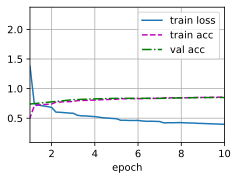

In [ ]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

In [ ]:
class LeNet_D5(d2l.Classifier):  
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.ReLU(),
            nn.Dropout(0.1),
            nn.LazyLinear(84), nn.ReLU(),
            nn.Dropout(0.1),
            nn.LazyLinear(num_classes),)

model = LeNet_D5()
model.layer_summary((1, 1, 32, 32))

Conv2d output shape:	 torch.Size([1, 6, 32, 32])
ReLU output shape:	 torch.Size([1, 6, 32, 32])
MaxPool2d output shape:	 torch.Size([1, 6, 16, 16])
Conv2d output shape:	 torch.Size([1, 16, 12, 12])
ReLU output shape:	 torch.Size([1, 16, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 16, 6, 6])
Flatten output shape:	 torch.Size([1, 576])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Dropout output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Dropout output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (1, 32, 32))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential(
  82.83 k, 100.000% Params, 605.0 KMac, 100.000% MACs, 
  (0): Conv2d(156, 0.188% Params, 159.74 KMac, 26.404% MACs, 1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 6.14 KMac, 1.016% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 6.14 KMac, 1.016% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(2.42 k, 2.917% Params, 347.9 KMac, 57.505% MACs, 6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU(0, 0.000% Params, 2.3 KMac, 0.381% MACs, )
  (5): MaxPool2d(0, 0.000% Params, 2.3 KMac, 0.381% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
  (7): Linear(69.24 k, 83.597% Params, 69.24 KMac, 11.445% MACs, in_features=576, out_features=120, bias=True)
  (8): ReLU(0, 0.000% Params, 120.0 Mac, 0.020% MACs, )
  (9): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.1, inplace=False)
  (10): Linear(10.16 k, 12.

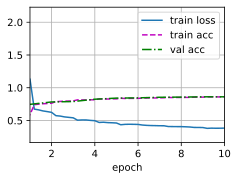

In [ ]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

#PROBLEM 4

In [ ]:
class AlexNet_Simplified(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(128, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(128, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), nn.Flatten(),
            nn.LazyLinear(256), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(128), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

model = AlexNet_Simplified()
model.layer_summary((1, 1, 128, 128))

Conv2d output shape:	 torch.Size([1, 32, 128, 128])
ReLU output shape:	 torch.Size([1, 32, 128, 128])
MaxPool2d output shape:	 torch.Size([1, 32, 64, 64])
Conv2d output shape:	 torch.Size([1, 64, 64, 64])
ReLU output shape:	 torch.Size([1, 64, 64, 64])
MaxPool2d output shape:	 torch.Size([1, 64, 32, 32])
Conv2d output shape:	 torch.Size([1, 128, 32, 32])
ReLU output shape:	 torch.Size([1, 128, 32, 32])
Conv2d output shape:	 torch.Size([1, 128, 32, 32])
ReLU output shape:	 torch.Size([1, 128, 32, 32])
Conv2d output shape:	 torch.Size([1, 64, 32, 32])
ReLU output shape:	 torch.Size([1, 64, 32, 32])
MaxPool2d output shape:	 torch.Size([1, 64, 16, 16])
Flatten output shape:	 torch.Size([1, 16384])
Linear output shape:	 torch.Size([1, 256])
ReLU output shape:	 torch.Size([1, 256])
Dropout output shape:	 torch.Size([1, 256])
Linear output shape:	 torch.Size([1, 128])
ReLU output shape:	 torch.Size([1, 128])
Dropout output shape:	 torch.Size([1, 128])
Linear output shape:	 torch.Size([1, 10])

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
macs, params = ptflops.get_model_complexity_info(model.net, (1, 128, 128))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential(
  4.54 M, 100.000% Params, 397.9 MMac, 100.000% MACs, 
  (0): Conv2d(832, 0.018% Params, 13.63 MMac, 3.426% MACs, 1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU(0, 0.000% Params, 524.29 KMac, 0.132% MACs, )
  (2): MaxPool2d(0, 0.000% Params, 524.29 KMac, 0.132% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(18.5 k, 0.407% Params, 75.76 MMac, 19.040% MACs, 32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(0, 0.000% Params, 262.14 KMac, 0.066% MACs, )
  (5): MaxPool2d(0, 0.000% Params, 262.14 KMac, 0.066% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(73.86 k, 1.626% Params, 75.63 MMac, 19.007% MACs, 64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(0, 0.000% Params, 131.07 KMac, 0.033% MACs, )
  (8): Conv2d(147.58 k, 3.248% Params, 151.13 MMac, 37.981% MACs, 128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(0, 0.

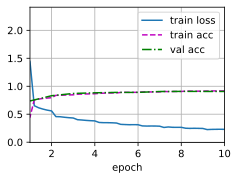

In [ ]:
model = AlexNet_Simplified(lr=0.1)
data = d2l.FashionMNIST(batch_size=128, resize=(128, 128))
lr, num_epochs = 0.1, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

#PROBLEM 5

In [25]:
# Resizing the Images to 32x32
data = FashionMNIST(resize = (28, 28))
# Printing the # of Training & Validation Images
print("Training Images   = ", len(data.train))
print("Validation Images = ", len(data.val))

data.train[0][0].shape

Training Images   =  60000
Validation Images =  10000


torch.Size([1, 28, 28])

In [29]:
class MyModel(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.LazyConv2d(64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.LazyConv2d(128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes)
        )
        self.net.apply(d2l.init_cnn)
        

model = MyModel()
model.layer_summary((1, 1, 28, 28))


Conv2d output shape:	 torch.Size([1, 32, 28, 28])
ReLU output shape:	 torch.Size([1, 32, 28, 28])
Conv2d output shape:	 torch.Size([1, 64, 28, 28])
ReLU output shape:	 torch.Size([1, 64, 28, 28])
Conv2d output shape:	 torch.Size([1, 128, 28, 28])
ReLU output shape:	 torch.Size([1, 128, 28, 28])
Conv2d output shape:	 torch.Size([1, 256, 28, 28])
ReLU output shape:	 torch.Size([1, 256, 28, 28])
MaxPool2d output shape:	 torch.Size([1, 256, 14, 14])
Flatten output shape:	 torch.Size([1, 50176])
Linear output shape:	 torch.Size([1, 512])
ReLU output shape:	 torch.Size([1, 512])
Dropout output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


In [30]:
macs, params = ptflops.get_model_complexity_info(model.net, (1, 28, 28))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential(
  26.08 M, 100.000% Params, 330.34 MMac, 100.000% MACs, 
  (0): Conv2d(320, 0.001% Params, 250.88 KMac, 0.076% MACs, 1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(0, 0.000% Params, 25.09 KMac, 0.008% MACs, )
  (2): Conv2d(18.5 k, 0.071% Params, 14.5 MMac, 4.390% MACs, 32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(0, 0.000% Params, 50.18 KMac, 0.015% MACs, )
  (4): Conv2d(73.86 k, 0.283% Params, 57.9 MMac, 17.528% MACs, 64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU(0, 0.000% Params, 100.35 KMac, 0.030% MACs, )
  (6): Conv2d(295.17 k, 1.132% Params, 231.41 MMac, 70.053% MACs, 128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(0, 0.000% Params, 200.7 KMac, 0.061% MACs, )
  (8): MaxPool2d(0, 0.000% Params, 200.7 KMac, 0.061% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(0, 0.000% Params, 0.0 Mac, 0.000% MACs, start_dim=1, end_dim=-1)
  (10): L

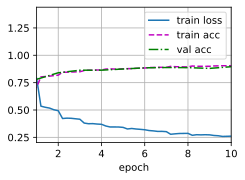

In [31]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())